In [1]:
import numpy as np
import triangle as tr
import matplotlib.pyplot as plt
import pandas as pd

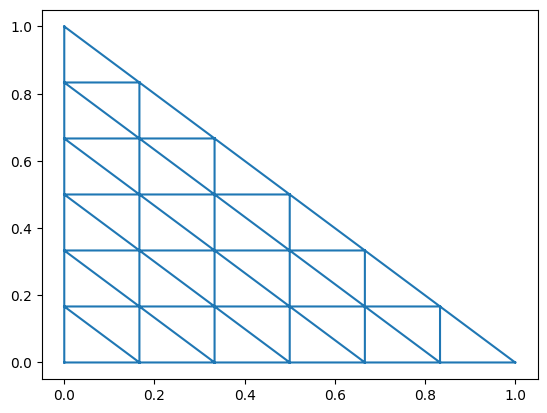

In [2]:
# Generate a mesh on the reference triangle with refinement level N (int)

def create_reference_mesh(N: int):
    N = N+1
    x = np.linspace(0, 1, N)
    xx, yy = np.meshgrid(x, x)
    xx = xx.flatten()
    yy = yy.flatten()
    filt = xx + yy <= 1
    grid = np.vstack([xx[filt], yy[filt]]).transpose()

    nodes_to_iterate = np.arange(0, (N + 1) * N // 2)
    nodes_to_drop = np.cumsum(np.arange(N, 0, -1)) - 1
    nodes_to_iterate = [i for i in nodes_to_iterate if i not in nodes_to_drop]

    cells = []
    w = N + 1
    for i in nodes_to_iterate:
        if i - 1 in nodes_to_iterate:
            cells.append([i, i + w, i + w - 1])
        else:
            w -= 1
        cells.append([i, i + 1, i + w])

    sub_mesh = tr.triangulate(dict(vertices=grid))
    sub_mesh["triangles"] = cells

    edges = [[[e[0], e[1]], [e[0], e[2]], [e[1], e[2]]] for e in cells]
    # edges = [np.array(e).flatten().tolist() for e in edges]
    edges = np.reshape(np.array(edges).flatten(), (-1, 2)).tolist()
    for e in edges:
        e.sort()
    edge_markers = np.zeros((len(edges), 1))
    dup_free = []
    dup_free_set = set()
    for e in edges:
        if tuple(e) not in dup_free_set:
            dup_free.append(e)
            dup_free_set.add(tuple(e))
        else:
            edge_markers[np.argwhere(dup_free == e)] = 1
    edges = dup_free

    sub_mesh["edges"] = edges
    return sub_mesh

ref_mesh = create_reference_mesh(6)
plt.triplot(ref_mesh['vertices'][:,0], ref_mesh['vertices'][:,1], ref_mesh['triangles'])
plt.show()

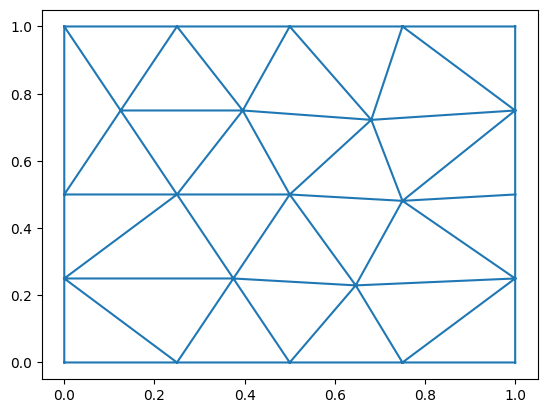

In [3]:
coarse_mesh = tr.triangulate(dict(vertices=[(0,0), (0,1), (1,0), (1,1)]), f"eqa0.05")
plt.triplot(coarse_mesh['vertices'][:,0], coarse_mesh['vertices'][:,1], coarse_mesh['triangles'])
plt.show()

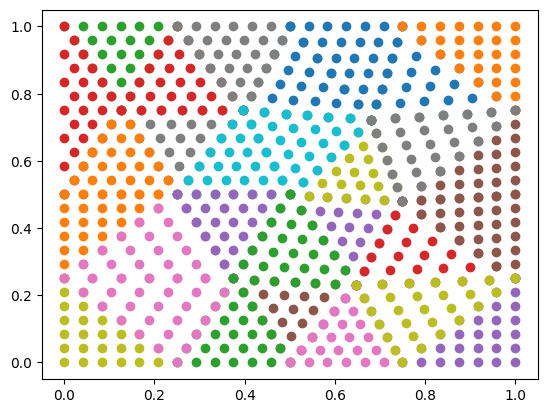

In [4]:
btol = []

n_ref_verts = len(ref_mesh['vertices'])
n_big_tri = len(coarse_mesh['triangles'])
n_little_tri = len(ref_mesh['triangles'])

def translate(nodes: list, vertices: list):
    """
    Translates given nodes in the reference
    case ([0, 0], [1, 0], [0, 1]) to an arbritrary triangle
    """

    # print(nodes)
    # print(vertices)

    output = np.zeros(shape=np.shape(nodes))

    output[:, 0] = (
        nodes[:, 0] * (vertices[1, 0] - vertices[0, 0])
        + nodes[:, 1] * (vertices[2, 0] - vertices[0, 0])
        + vertices[0, 0]
    )

    output[:, 1] = (
        nodes[:, 0] * (vertices[1, 1] - vertices[0, 1])
        + nodes[:, 1] * (vertices[2, 1] - vertices[0, 1])
        + vertices[0, 1]
    )

    det = (vertices[1, 0] - vertices[0, 0]) * (vertices[2, 1] - vertices[0, 1]) - (
        vertices[2, 0] - vertices[0, 0]
    ) * (vertices[1, 1] - vertices[0, 1])

    return output, det / 2

little_triangles = []
global_edges = []
global_triangles = []
for i, big_triangle in enumerate(coarse_mesh['triangles']):
    arb_triangle, _ = translate(ref_mesh["vertices"], coarse_mesh['vertices'][big_triangle])
    
    little_triangles.append(np.array(arb_triangle))
    plt.scatter(little_triangles[-1][:,0], little_triangles[-1][:,1], marker='o')

    global_edges.append(np.array(ref_mesh['edges']) + i*n_ref_verts)
    global_triangles.append(np.array(ref_mesh['triangles']) + i*n_ref_verts)

    btol.append(list(np.arange(i*n_little_tri, (i+1)*n_little_tri)))

In [5]:
fine_mesh = np.reshape(little_triangles, (-1,2))
coord_df = pd.DataFrame({'x': np.round(fine_mesh[:,0], 5), 'y': np.round(fine_mesh[:,1], 5)})
coord_df.reset_index(inplace=True, drop=True)
print(coord_df)

           x        y
0    0.68087  0.72206
1    0.73406  0.72672
2    0.78725  0.73138
3    0.84044  0.73603
4    0.89362  0.74069
..       ...      ...
807  0.72258  0.19462
808  0.76424  0.23629
809  0.66364  0.19119
810  0.70530  0.23286
811  0.64636  0.22943

[812 rows x 2 columns]


In [6]:
df1 = (coord_df.groupby(['x', 'y'], sort=False).apply(lambda x: list(x.index))).reset_index(name='idx')
replace_maps = df1.idx.values
replace_maps = [r for r in replace_maps if len(r) > 1]
# to_put = [l[0] for l in replace_maps]
# to_replace = [l[1:] for l in replace_maps]

to_put = {l[0]:l[1:] for l in replace_maps}

to_delete = []
for l in replace_maps:
    to_delete += l[1:]

print(to_put)
print(to_delete)
# print(to_replace)

{0: [307, 510, 559, 560, 783], 1: [782], 2: [780], 3: [777], 4: [773], 5: [768], 6: [426, 594, 762], 7: [561], 12: [593], 13: [562], 17: [592], 18: [563], 21: [591], 22: [564], 24: [590], 25: [565], 26: [589], 27: [566, 588], 28: [174, 230, 448], 29: [173], 30: [172], 31: [171], 32: [170], 33: [169], 34: [168, 196, 258, 314, 398], 40: [313], 45: [312], 49: [311], 52: [310], 54: [309], 55: [111, 308], 56: [370, 476], 62: [90], 63: [376], 68: [89], 69: [381], 73: [88], 74: [385], 77: [87], 78: [388], 80: [86], 81: [390], 82: [85], 83: [84, 223, 335, 391], 91: [333], 97: [330], 102: [326], 106: [321], 109: [315], 112: [279, 392, 531, 538, 616], 113: [623], 114: [629], 115: [634], 116: [638], 117: [641], 118: [140, 643, 650, 728, 811], 119: [529], 124: [649], 125: [526], 129: [648], 130: [522], 133: [647], 134: [517], 136: [646], 137: [511], 138: [645], 139: [447, 504, 644, 700, 756], 141: [642], 142: [640], 143: [637], 144: [633], 145: [628], 146: [195, 342, 419, 475, 622], 147: [729], 15

In [7]:
global_edges = np.reshape(global_edges, (-1,2))
global_triangles = np.reshape(global_triangles, (-1,3))
global_vertices = coord_df.index.values

In [8]:
def find_and_replace(A, to_put, to_replace):
    argies = np.zeros(np.shape(A))
    for i in to_replace:
        argies += (A == i)
    A[argies.astype(bool)] = to_put
    return A

for k, v in to_put.items():
    global_edges = find_and_replace(global_edges, k, v)
    global_triangles = find_and_replace(global_triangles, k, v)
    global_vertices = find_and_replace(global_vertices, k, v)

In [9]:
print(len(global_edges))
print(len(global_triangles))
print(len(global_vertices))

1827
1044
812


In [10]:
global_edges = np.sort(global_edges, axis=1)
dup = pd.DataFrame(global_edges).duplicated(keep='first')
print(np.sum(pd.DataFrame(global_edges).duplicated(keep='first')))
global_edges = global_edges[~dup]
# print(np.sum(pd.DataFrame(global_edges).duplicated()))

global_triangles = np.sort(global_triangles, axis=1)
dup = pd.DataFrame(global_triangles).duplicated(keep='first')
global_triangles = global_triangles[~dup]

dup = pd.Series(global_vertices).duplicated(keep='first')
coord_df_filtered = coord_df[~dup]
old = coord_df_filtered.index.values
coord_df_filtered = coord_df_filtered.reset_index(drop=True)
new = coord_df_filtered.index.values

for i,k in enumerate(old):
    global_triangles = find_and_replace(global_triangles, new[i], [k])
    global_edges = find_and_replace(global_edges, new[i], [k])

# print(old, new)

# print(len(global_edges))
# print(len(global_triangles))
# print(coord_df[['x', 'y']].duplicated())
# abc = coord_df.duplicated(keep='first')
# print(abc)

216


In [11]:
def is_on_boundary(x,y):
    """
    Defined on unit square
    """
    lr = (x == 0) + (x == 1)
    ud = (y == 0) + (y == 1)

    return (lr + ud).astype(int)

def find_midpoints(edges):
    mx = np.sum(edges[:,:,0], axis=1)/2
    my = np.sum(edges[:,:,1], axis=1)/2

    return np.array([mx,my]).T

In [12]:
print(global_triangles)

[[  0   1   7]
 [  1   7   8]
 [  1   2   8]
 ...
 [470 528 567]
 [470 475 567]
 [110 470 528]]


In [13]:
a = coord_df_filtered[['x', 'y']].values
b = a[global_edges]
midpoints = find_midpoints(b)

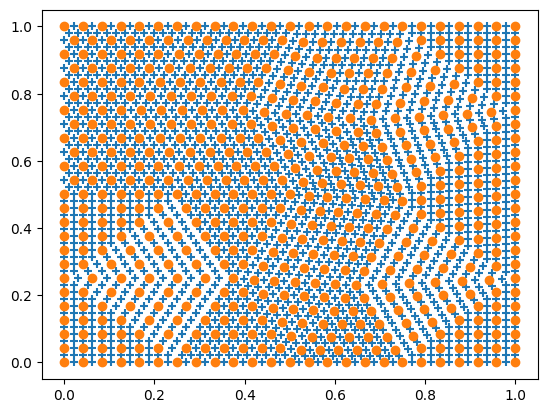

In [14]:
plt.scatter(midpoints[:,0], midpoints[:,1],marker='+')
plt.scatter(coord_df_filtered.x.values, coord_df_filtered.y.values)

In [15]:
vertex_markers = is_on_boundary(coord_df_filtered.x.values, coord_df_filtered.y.values)
edge_markers = is_on_boundary(midpoints[:,0], midpoints[:,1])

print(len(edge_markers))
print(sum(edge_markers))

1611
90


In [16]:
# TODO:
# - plot everything
#     - only sub_mesh 
#     - only coarse_mesh
#     - nodes on boundary via edge_markers
#     - nodes on boundary via vertex_markers
#     - plot btol proof
#     - 



In [17]:
# coord_df = coord_df.drop(to_delete)
# test = coord_df.reset_index()
# print(test)
# test = test.drop('index', axis=1)
# for i,k in enumerate(test.level_0.values):
#     global_triangles = find_and_replace(global_triangles, test.index.values[i], [k])

# vertex_markers = is_on_boundary(test.x.values, test.y.values)

mesh = {
        'vertices': np.array([coord_df_filtered.x.values,coord_df_filtered.y.values]).T,
        # 'edges': global_edges,
        'triangles': global_triangles,
        # 'vertex_markers': vertex_markers,
        # 'edge_markers': edge_markers
}

1611
1611
90


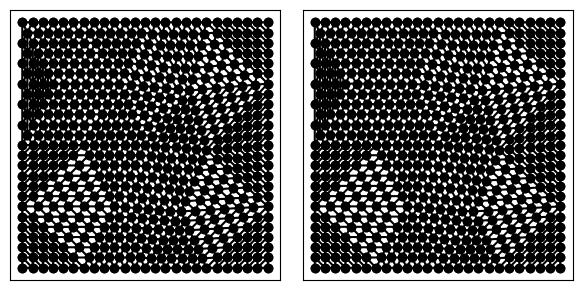

In [18]:
A = tr.triangulate(mesh, 'er')
tr.compare(plt, A, mesh)

A['vertex_markers'] = vertex_markers
A['edge_markers'] = edge_markers
A['edges'] = global_edges

print(len(edge_markers))
print(len(global_edges))
print(sum(edge_markers))

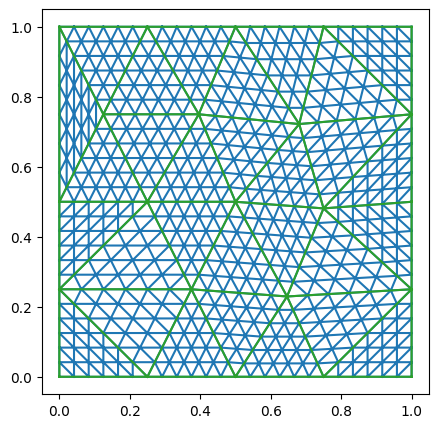

In [19]:
plt.figure(figsize=(5,5))
plt.triplot(A['vertices'][:,0], A['vertices'][:,1], A['triangles'])
plt.triplot(coarse_mesh['vertices'][:,0], coarse_mesh['vertices'][:,1], coarse_mesh['triangles'])

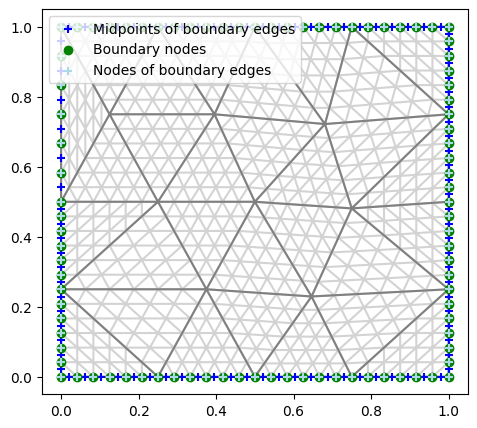

In [20]:
filt = np.array(A['vertex_markers']).astype(bool)
nodes_on_boundary = np.array(A['vertices'])[filt]

filt = np.array(A['edge_markers']).astype(bool).flatten()
nodes_of_edges_on_boundary = A['vertices'][A['edges'][filt]]
nodes_of_edges_on_boundary = np.reshape(nodes_of_edges_on_boundary, (-1,2))

mids = midpoints[filt]
plt.figure(figsize=(5.5,5))
plt.scatter(mids[:,0], mids[:,1], marker='+', color='blue',label='Midpoints of boundary edges')
plt.scatter(nodes_on_boundary[:,0], nodes_on_boundary[:,1], color='green',label='Boundary nodes')
plt.scatter(nodes_of_edges_on_boundary[:,0], nodes_of_edges_on_boundary[:,1], color='lightblue',marker='+', label='Nodes of boundary edges')
plt.triplot(A['vertices'][:,0], A['vertices'][:,1], A['triangles'], color='lightgrey', zorder=-1)
plt.triplot(coarse_mesh['vertices'][:,0], coarse_mesh['vertices'][:,1], coarse_mesh['triangles'], color='grey', zorder=-1)
plt.legend()

In [21]:
print(len(A['vertices']))
print(len(A['edges']))
print(len(A['triangles']))
print(sum(A['edge_markers']))
print(sum(A['vertex_markers']))

568
1611
1044
90
90


In [22]:
print(btol[9])

[324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]


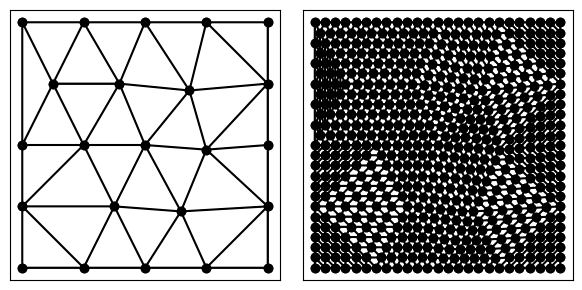

In [23]:
tr.compare(plt, coarse_mesh, A)

In [24]:
print(A['vertices'])

[[0.68087 0.72206]
 [0.73406 0.72672]
 [0.78725 0.73138]
 ...
 [0.73985 0.15638]
 [0.78151 0.19805]
 [0.72258 0.19462]]
